# 2.1

Imports


In [24]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np


## 1. Load Pretrained ViT (ImageNet-1k pretrained)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

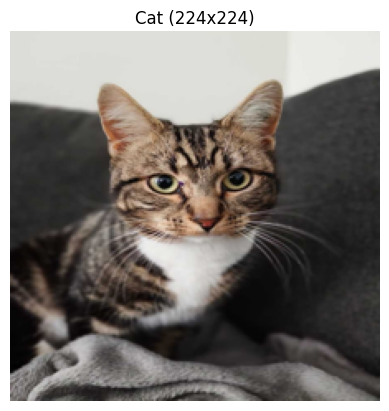

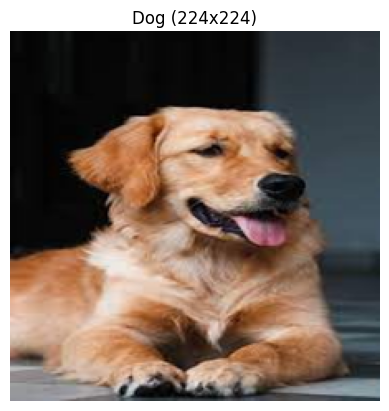

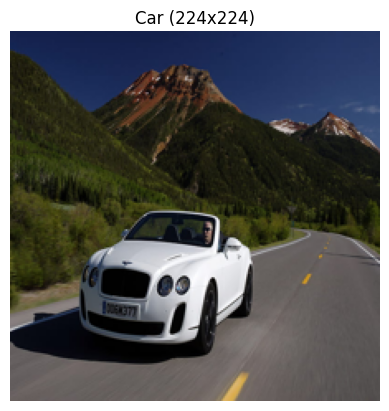

In [21]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

#load your custom images
image_paths = ["cat.jpg", "dog.jpg", "car.jpg"]
images = [Image.open(p).convert("RGB") for p in image_paths]

# preprocess for ViT
inputs = processor(images=images, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    preds = logits.argmax(dim=-1)

# map class ids -> labels
pred_labels = [model.config.id2label[p.item()] for p in preds]

def display_resized(img, title=""):
    resized = img.resize((224, 224))  # force resize for display
    plt.imshow(resized)
    plt.axis("off")
    plt.title(title)
    plt.show()
    return resized

cat_resized = display_resized(Image.open("cat.jpg"), "Cat (224x224)")
dog_resized = display_resized(Image.open("dog.jpg"), "Dog (224x224)")
car_resized = display_resized(Image.open("car.jpg"), "Car (224x224)")


## 2.2

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

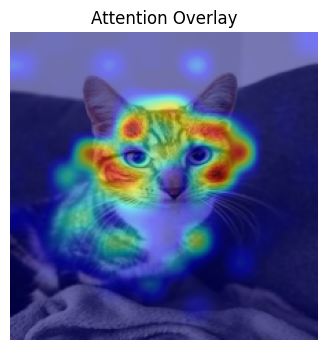

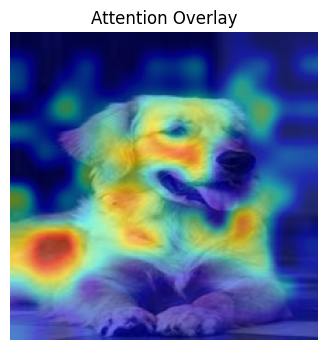

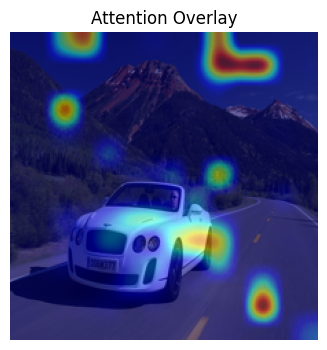

In [62]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image

# Load pretrained ViT with attention
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    output_attentions=True
).eval()

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

def visualize_attention(img_path, model, processor):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    inputs = processor(images=img, return_tensors="pt")

    # Forward pass with attentions
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions  # list of layer attentions
    last_attn = attentions[-1]       # shape [1, heads, tokens, tokens]

    # Average across heads
    if img_path =='car.jpg':
      cls_attn = last_attn[0, 7, 0, 1:].reshape(14, 14).numpy()  # head 5 as example
    else:
      cls_attn = last_attn[0, 1, 0, 1:].reshape(14, 14).numpy()  # head 5 as example


    # CLS token is index 0
    # cls_attn = attn_map[0, 1:].reshape(14, 14).numpy()

    # Normalize
    cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())

    # Resize to image size
    cls_attn_resized = np.array(Image.fromarray((cls_attn*255).astype(np.uint8)).resize(img.size))

    # Overlay
    fig, ax = plt.subplots(1, 1, figsize=(8, 4)) # Changed to 1,1
    ax.imshow(img) # Removed index [0]
    ax.imshow(cls_attn_resized, cmap="jet", alpha=0.5) # Removed index [0]
    ax.set_title("Attention Overlay") # Removed index [0]
    ax.axis("off") # Removed index [0]
    plt.show()

    return cls_attn_resized

# Example usage
attn_cat = visualize_attention("cat.jpg", model, processor)
attn_dog = visualize_attention("dog.jpg", model, processor)
attn_car = visualize_attention("car.jpg", model, processor)

## 2.3 Analyzing the Attention Map

The attention maps reveal clear differences in how the Vision Transformer allocates focus across patches.
For the \textbf{cat} and \textbf{dog} images, the selected attention heads strongly highlighted the regions corresponding to the face and body, effectively outlining the primary objects of interest.
This shows that certain heads in the ViT learn to specialize in object localization and provide interpretable cues aligned with the classification task.

In contrast, for the \textbf{car} image, the attention appeared more diffuse, with some heads focusing on background context rather than the car itself.
This suggests that not all heads provide equally meaningful explanations and that ViTs distribute roles across heads, with some capturing object-level detail while others attend to contextual surroundings.

\paragraph{Comparison to CNNs.}
Traditional CNNs do not have built-in attention maps.
Instead, interpretability typically relies on methods such as \textit{Class Activation Mapping (CAM)} or \textit{Grad-CAM}, which backpropagate gradients to highlight salient regions.
These methods often emphasize the most discriminative parts of the object (e.g., a dog's face) but require additional computation.

In contrast, ViTs provide attention weights natively through their transformer layers, making interpretability more direct.
Furthermore, ViT attention can capture global context (since every patch attends to every other), whereas CNN-based CAM methods tend to emphasize only local receptive fields.

\paragraph{Observations.}
The strong alignment of ViT attention with object regions for cat and dog images demonstrates its interpretability advantage, while the weaker car visualization highlights the variability across attention heads.
This suggests that ViTs inherently offer a spectrum of explanations, some object-focused and some context-focused, which can be complementary in understanding model decisions.


# 2.4: Masking Patches at Inference

In [67]:
import torch.nn.functional as F

def mask_patches(img, mode="random", frac=0.3, patch_size=16):
    """
    Mask patches in the input image.
    mode = "random" or "center"
    frac = fraction of patches to mask
    """
    w, h = img.size
    img = np.array(img)

    num_patches_w, num_patches_h = w // patch_size, h // patch_size
    mask = np.ones((num_patches_h, num_patches_w))

    if mode == "random":
        num_mask = int(frac * mask.size)
        idx = np.random.choice(mask.size, num_mask, replace=False)
        mask.ravel()[idx] = 0
    elif mode == "center":
        cw, ch = num_patches_w // 2, num_patches_h // 2
        mask[ch-2:ch+2, cw-2:cw+2] = 0  # 4x4 center block masked

    # Apply mask
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            if mask[i, j] == 0:
                img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0

    return Image.fromarray(img.astype(np.uint8))

import torch.nn.functional as F

def predict_with_confidence(img, model, processor, topk=1):
    inputs = processor(images=img, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    top_probs, top_ids = probs.topk(topk, dim=-1)
    top_labels = [model.config.id2label[idx.item()] for idx in top_ids[0]]
    return list(zip(top_labels, top_probs[0].tolist()))

images = ["dog.jpg", "cat.jpg", "car.jpg"]

for img_path in images:
    print(f"\nMasking image: {img_path}")
    img = Image.open(img_path).resize((224,224)).convert("RGB")

    # Original
    original = predict_with_confidence(img, model, processor)[0]
    print(f"Original prediction: {original[0]} ({original[1]*100:.2f}%)")

    # Masking
    for mode in ["random", "center"]:
        masked = mask_patches(img, mode=mode, frac=0.3)
        pred, conf = predict_with_confidence(masked, model, processor)[0]
        print(f"{mode.capitalize()} masked prediction: {pred} ({conf*100:.2f}%)")
        masked.show()





Masking image: dog.jpg
Original prediction: golden retriever (97.40%)
Random masked prediction: golden retriever (96.81%)
Center masked prediction: golden retriever (96.39%)

Masking image: cat.jpg
Original prediction: tabby, tabby cat (73.67%)
Random masked prediction: tabby, tabby cat (79.65%)
Center masked prediction: tabby, tabby cat (69.72%)

Masking image: car.jpg
Original prediction: sports car, sport car (93.18%)
Random masked prediction: convertible (78.39%)
Center masked prediction: sports car, sport car (53.86%)


## 2.5: Linear probes: CLS token vs mean of patch tokens

In [ ]:
import torch, numpy as np
from transformers import ViTModel, ViTImageProcessor
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, Subset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224"

# Config
use_subset = True        # set False to use full dataset
subset_ratio = 0.1       # fraction of train/val to use when use_subset=True
batch_size = 64

# Load model (feature extractor) and processor
vit = ViTModel.from_pretrained(model_name).to(device)
processor = ViTImageProcessor.from_pretrained(model_name)

# Prepare CIFAR-10 (resize to 224)
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_ds   = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

if use_subset:
    train_n = int(len(train_ds) * subset_ratio)
    val_n   = int(len(val_ds) * subset_ratio)
    train_ds = Subset(train_ds, list(range(train_n)))
    val_ds   = Subset(val_ds, list(range(val_n)))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

def extract_token_features(model, loader, pooling="cls"):
    """
    pooling: "cls" or "mean"
    returns: (N, D) numpy array of features and labels numpy array
    """
    feats = []
    labs  = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(pixel_values=images)  # last_hidden_state: [B, seq_len, hidden]
            hidden = outputs.last_hidden_state   # torch tensor
            if pooling == "cls":
                f = hidden[:, 0, :]         # CLS token
            else:
                f = hidden[:, 1:, :].mean(dim=1)  # mean of patch tokens
            feats.append(f.cpu())
            labs.extend(labels.numpy())
    feats = torch.cat(feats, dim=0).numpy()
    labs  = np.array(labs)
    return feats, labs

# Extract features (train + val) for both pooling kinds
print("Extracting CLS features (train/val)...")
cls_train_X, cls_train_y = extract_token_features(vit, train_loader, pooling="cls")
cls_val_X,   cls_val_y   = extract_token_features(vit, val_loader, pooling="cls")

print("Extracting Mean-patch features (train/val)...")
mean_train_X, mean_train_y = extract_token_features(vit, train_loader, pooling="mean")
mean_val_X,   mean_val_y   = extract_token_features(vit, val_loader, pooling="mean")

# Sanity: shapes
print("CLS train shape:", cls_train_X.shape, "val shape:", cls_val_X.shape)
print("MEAN train shape:", mean_train_X.shape, "val shape:", mean_val_X.shape)

# Train simple logistic regression probes (sklearn) - fast and reliable for small subsets
def train_logistic_probe(X_train, y_train, X_val, y_val, C=1.0):
    # solver 'saga' with multinomial for multi-class; increase max_iter if needed
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga', C=C)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc, clf

print("\nTraining linear probe on CLS token features...")
cls_acc, cls_clf = train_logistic_probe(cls_train_X, cls_train_y, cls_val_X, cls_val_y)
print(f"CLS probe val accuracy: {cls_acc*100:.2f}%")

print("\nTraining linear probe on MEAN-patch features...")
mean_acc, mean_clf = train_logistic_probe(mean_train_X, mean_train_y, mean_val_X, mean_val_y)
print(f"Mean-pool probe val accuracy: {mean_acc*100:.2f}%")

# Print quick comparison
print("\n=== Summary ===")
print(f"CLS probe accuracy:  {cls_acc*100:.2f}%")
print(f"Mean probe accuracy: {mean_acc*100:.2f}%")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting CLS features (train/val)...
Extracting Mean-patch features (train/val)...
